In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Load data
X = pd.read_csv("./data_31_40/problem_36/dataset_36.csv")
y = pd.read_csv("./data_31_40/problem_36/target_36.csv")

# Select target02 for Part 2
y2 = y["target02"]

# Sanity checks
print("X shape:", X.shape)
print("y shape:", y.shape)
print("y2 shape:", y2.shape)

assert list(X.columns) == [f"feat_{i}" for i in range(X.shape[1])], "Unexpected feature columns/order!"

print("Total missing values in X:", X.isna().sum().sum())

# Convert to NumPy
X_np = X.values
y_np = y2.values


X shape: (10000, 273)
y shape: (10000, 2)
y2 shape: (10000,)
Total missing values in X: 0


In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
importances = []

for train_idx, _ in kf.split(X_np):
    tree = DecisionTreeRegressor(
        max_depth=4,
        min_samples_leaf=50,
        random_state=42
    )
    tree.fit(X_np[train_idx], y_np[train_idx])
    importances.append(tree.feature_importances_)

importances = np.array(importances)
mean_importance = importances.mean(axis=0)
std_importance = importances.std(axis=0)

ranked = np.argsort(mean_importance)[::-1]

print("\nTop 10 features by importance:")
for i in range(10):
    idx = ranked[i]
    print(f"Rank {i+1}: feat_{idx}, mean_imp={mean_importance[idx]:.4f}, std={std_importance[idx]:.4f}")



Top 10 features by importance:
Rank 1: feat_49, mean_imp=0.8262, std=0.0022
Rank 2: feat_169, mean_imp=0.1376, std=0.0025
Rank 3: feat_55, mean_imp=0.0362, std=0.0006
Rank 4: feat_30, mean_imp=0.0000, std=0.0000
Rank 5: feat_29, mean_imp=0.0000, std=0.0000
Rank 6: feat_28, mean_imp=0.0000, std=0.0000
Rank 7: feat_27, mean_imp=0.0000, std=0.0000
Rank 8: feat_26, mean_imp=0.0000, std=0.0000
Rank 9: feat_25, mean_imp=0.0000, std=0.0000
Rank 10: feat_24, mean_imp=0.0000, std=0.0000



Decision Tree structure (text view):
|--- feat_49 <= 0.500
|   |--- feat_49 <= 0.200
|   |   |--- feat_55 <= 0.503
|   |   |   |--- feat_169 <= 0.439
|   |   |   |   |--- value: [-0.343]
|   |   |   |--- feat_169 >  0.439
|   |   |   |   |--- value: [-0.662]
|   |   |--- feat_55 >  0.503
|   |   |   |--- feat_169 <= 0.570
|   |   |   |   |--- value: [-0.796]
|   |   |   |--- feat_169 >  0.570
|   |   |   |   |--- value: [-1.116]
|   |--- feat_49 >  0.200
|   |   |--- feat_55 <= 0.511
|   |   |   |--- feat_169 <= 0.534
|   |   |   |   |--- value: [0.594]
|   |   |   |--- feat_169 >  0.534
|   |   |   |   |--- value: [0.973]
|   |   |--- feat_55 >  0.511
|   |   |   |--- feat_169 <= 0.493
|   |   |   |   |--- value: [1.202]
|   |   |   |--- feat_169 >  0.493
|   |   |   |   |--- value: [1.585]
|--- feat_49 >  0.500
|   |--- feat_169 <= 0.536
|   |   |--- feat_169 <= 0.266
|   |   |   |--- feat_169 <= 0.116
|   |   |   |   |--- value: [-0.227]
|   |   |   |--- feat_169 >  0.116
|   |   |

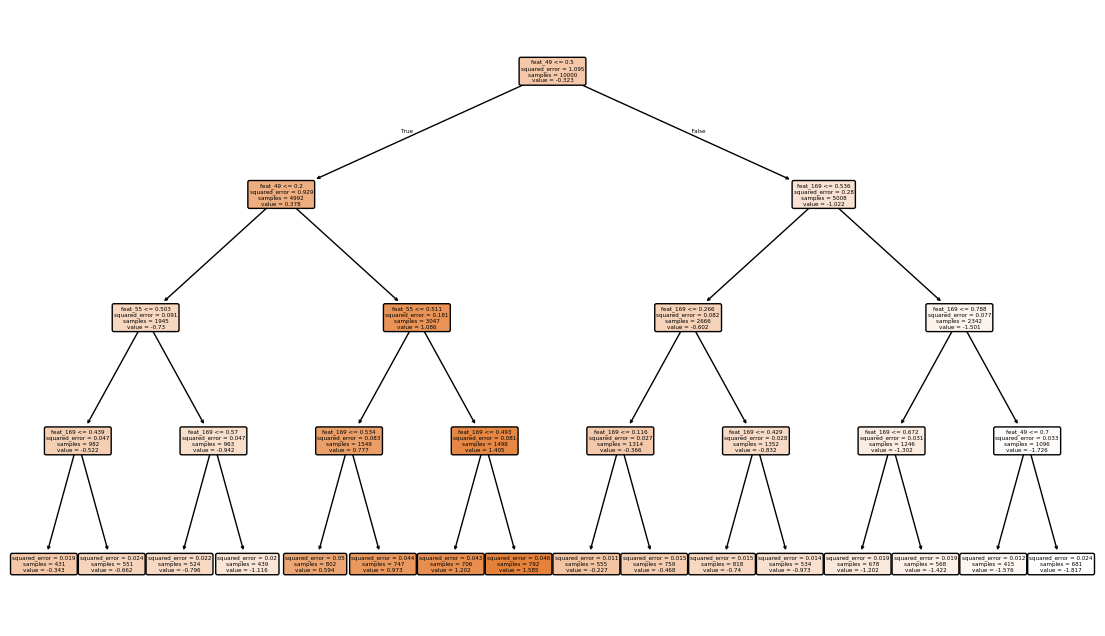

In [7]:
from sklearn.tree import export_text

# Train a single representative tree on ALL data
tree_inspect = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=50,
    random_state=42
)
tree_inspect.fit(X_np, y_np)
# Show tree structure as text
feature_names = [f"feat_{i}" for i in range(X_np.shape[1])]

tree_text = export_text(
    tree_inspect,
    feature_names=feature_names,
    decimals=3
)

print("\nDecision Tree structure (text view):")
print(tree_text)


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plot_tree(
    tree_inspect,
    feature_names=[f"feat_{i}" for i in range(X_np.shape[1])],
    filled=True,
    rounded=True,
    max_depth=4
)
plt.savefig("tree_feat49.svg", format="svg", bbox_inches="tight")
plt.show()


plt.close()


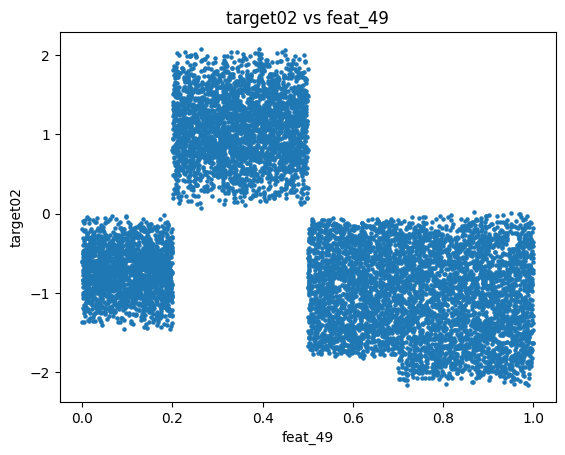

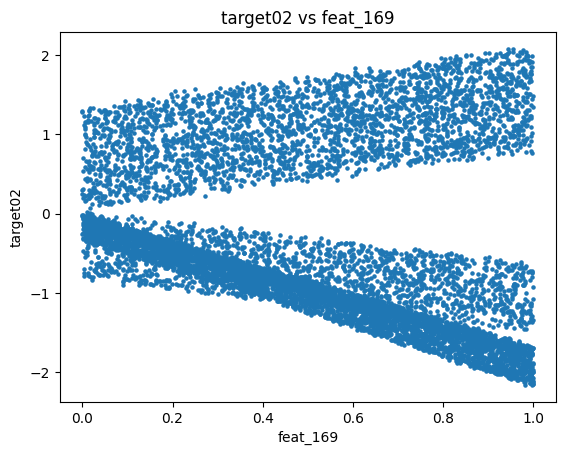

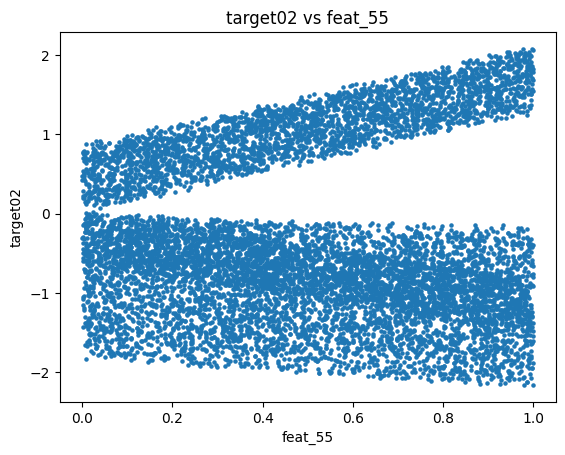


Global linear fit diagnostics:
feat_49: R^2 = 0.1747
feat_169: R^2 = 0.0432
feat_55: R^2 = 0.0003


In [ ]:
selected_features = [49, 169, 55]

for feat_idx in selected_features:
    plt.figure()
    plt.scatter(X_np[:, feat_idx], y_np, s=5)
    plt.xlabel(f"feat_{feat_idx}")
    plt.ylabel("target02")
    plt.title(f"target02 vs feat_{feat_idx}")
    plt.show()

print("\nGlobal linear fit diagnostics:")
for feat_idx in selected_features:
    lr = LinearRegression()
    lr.fit(X_np[:, feat_idx].reshape(-1, 1), y_np)
    r2 = lr.score(X_np[:, feat_idx].reshape(-1, 1), y_np)
    print(f"feat_{feat_idx}: R^2 = {r2:.4f}")


In [ ]:
X_feat49 = X_np[:, 49].reshape(-1, 1)

tree_49 = DecisionTreeRegressor(
    max_depth=2,
    min_samples_leaf=100,
    random_state=42
)
tree_49.fit(X_feat49, y_np)

thresholds = tree_49.tree_.threshold
thresholds = thresholds[thresholds != -2]

print("\nDetected thresholds for feat_49:", thresholds)



Detected thresholds for feat_49: [0.49999121 0.19998217 0.70420182]


In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text
import matplotlib.pyplot as plt

# Use only feat_49
X_feat49 = X_np[:, 49].reshape(-1, 1)

tree_49 = DecisionTreeRegressor(
    max_depth=2,
    min_samples_leaf=100,
    random_state=42
)
tree_49.fit(X_feat49, y_np)

# ---- Extract thresholds ----
thresholds = tree_49.tree_.threshold
thresholds = thresholds[thresholds != -2]

print("\nDetected thresholds for feat_49:", thresholds)




Detected thresholds for feat_49: [0.49999121 0.19998217 0.70420182]


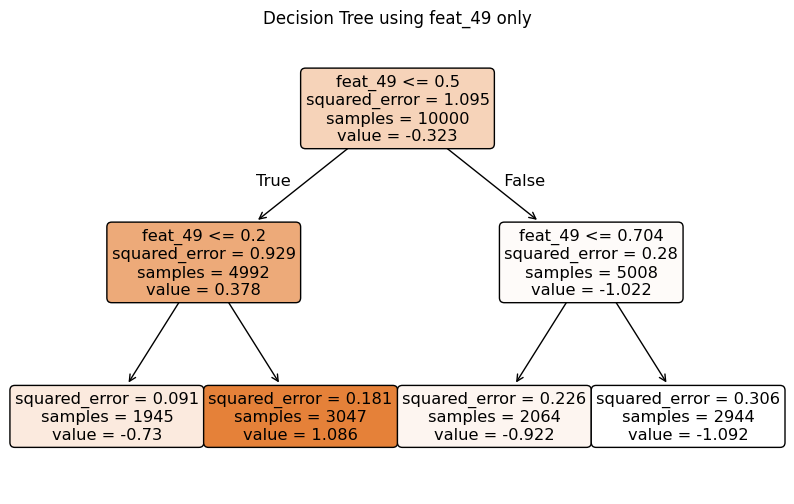

In [ ]:
plt.figure(figsize=(10, 6))
from sklearn.tree import plot_tree

plot_tree(
    tree_49,
    feature_names=["feat_49"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree using feat_49 only")
plt.show()


In [ ]:
tree_rules = export_text(
    tree_49,
    feature_names=["feat_49"]
)

print("\nDecision Tree structure (text view):")
print(tree_rules)



Decision Tree structure (text view):
|--- feat_49 <= 0.50
|   |--- feat_49 <= 0.20
|   |   |--- value: [-0.73]
|   |--- feat_49 >  0.20
|   |   |--- value: [1.09]
|--- feat_49 >  0.50
|   |--- feat_49 <= 0.70
|   |   |--- value: [-0.92]
|   |--- feat_49 >  0.70
|   |   |--- value: [-1.09]



In [ ]:
regimes = [
    X_np[:, 49] <= 0.20,
    (X_np[:, 49] > 0.20) & (X_np[:, 49] <= 0.50),
    (X_np[:, 49] > 0.50) & (X_np[:, 49] <= 0.70),
    X_np[:, 49] > 0.70
]

print("\nPer-regime linear models:")
for i, mask in enumerate(regimes):
    X_reg = X_np[mask][:, 169].reshape(-1, 1)
    y_reg = y_np[mask]

    lr = LinearRegression()
    lr.fit(X_reg, y_reg)

    a = lr.coef_[0]
    b = lr.intercept_
    r2 = lr.score(X_reg, y_reg)

    print(
        f"Regime {i+1}: samples={len(y_reg)}, "
        f"target02 ≈ {a:.3f} * feat_169 + {b:.3f}, R^2={r2:.3f}"
    )



Per-regime linear models:
Regime 1: samples=1946, target02 ≈ -0.638 * feat_169 + -0.407, R^2=0.366
Regime 2: samples=3046, target02 ≈ 0.760 * feat_169 + 0.698, R^2=0.269
Regime 3: samples=2014, target02 ≈ -1.651 * feat_169 + -0.100, R^2=0.991
Regime 4: samples=2994, target02 ≈ -1.858 * feat_169 + -0.147, R^2=0.966


In [ ]:
def predict_rule_system(X):
    preds = np.zeros(len(X))

    f49 = X[:, 49]
    f169 = X[:, 169]

    preds[f49 <= 0.20] = -0.638 * f169[f49 <= 0.20] - 0.407

    mask = (f49 > 0.20) & (f49 <= 0.50)
    preds[mask] = 0.760 * f169[mask] + 0.698

    mask = (f49 > 0.50) & (f49 <= 0.70)
    preds[mask] = -1.651 * f169[mask] - 0.100

    preds[f49 > 0.70] = -1.858 * f169[f49 > 0.70] - 0.147

    return preds


In [ ]:
y_true = y_np
y_pred = predict_rule_system(X_np)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\nOverall error metrics:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R^2  = {r2:.4f}")



Overall error metrics:
MAE  = 0.1697
RMSE = 0.2347
R^2  = 0.9497


In [ ]:
regime_masks = {
    "Regime 1 (feat_49 <= 0.20)": (X_np[:, 49] <= 0.20),
    "Regime 2 (0.20 < feat_49 <= 0.50)": ((X_np[:, 49] > 0.20) & (X_np[:, 49] <= 0.50)),
    "Regime 3 (0.50 < feat_49 <= 0.70)": ((X_np[:, 49] > 0.50) & (X_np[:, 49] <= 0.70)),
    "Regime 4 (feat_49 > 0.70)": (X_np[:, 49] > 0.70),
}

print("\nPer-regime error metrics:")
print("-" * 50)

for name, mask in regime_masks.items():
    y_t = y_true[mask]
    y_p = y_pred[mask]

    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    r2 = r2_score(y_t, y_p)

    print(f"{name}:")
    print(f"  Samples = {len(y_t)}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R^2  = {r2:.4f}")
    print()




Per-regime error metrics:
--------------------------------------------------
Regime 1 (feat_49 <= 0.20):
  Samples = 1946
  MAE  = 0.2075
  RMSE = 0.2416
  R^2  = 0.3659

Regime 2 (0.20 < feat_49 <= 0.50):
  Samples = 3046
  MAE  = 0.3122
  RMSE = 0.3633
  R^2  = 0.2691

Regime 3 (0.50 < feat_49 <= 0.70):
  Samples = 2014
  MAE  = 0.0388
  RMSE = 0.0456
  R^2  = 0.9907

Regime 4 (feat_49 > 0.70):
  Samples = 2994
  MAE  = 0.0883
  RMSE = 0.1019
  R^2  = 0.9661

